In [68]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import multiprocessing
import re
import os
import srt
import nltk
import codecs
import gensim.models.word2vec as w2v
from gensim.models import FastText
import sklearn.manifold
import glob
import lxml.etree
%matplotlib inline

# Word2Vec using srt files

In [2]:
srt_filenames = sorted(glob.glob("himym/*.srt"))
srt_filenames

['himym/How.I.Met.Your.Mother.S01E01.DVDRip.XviD-TOPAZ.EnglishHI.srt',
 'himym/How.I.Met.Your.Mother.S01E02.DVDRip.XviD-TOPAZ.EnglishHI.srt',
 'himym/How.I.Met.Your.Mother.S01E03.DVDRip.XviD-TOPAZ.EnglishHI.srt',
 'himym/How.I.Met.Your.Mother.S01E04.DVDRip.XviD-TOPAZ.EnglishHI.srt',
 'himym/How.I.Met.Your.Mother.S01E05.DVDRip.XviD-TOPAZ.EnglishHI.srt',
 'himym/How.I.Met.Your.Mother.S01E06.DVDRip.XviD-TOPAZ.EnglishHI.srt',
 'himym/How.I.Met.Your.Mother.S01E07.DVDRip.XviD-TOPAZ.EnglishHI.srt',
 'himym/How.I.Met.Your.Mother.S01E08.DVDRip.XviD-TOPAZ.EnglishHI.srt',
 'himym/How.I.Met.Your.Mother.S01E09.DVDRip.XviD-TOPAZ.EnglishHI.srt',
 'himym/How.I.Met.Your.Mother.S01E10.DVDRip.XviD-TOPAZ.EnglishHI.srt',
 'himym/How.I.Met.Your.Mother.S01E11.DVDRip.XviD-TOPAZ.EnglishHI.srt',
 'himym/How.I.Met.Your.Mother.S01E12.DVDRip.XviD-TOPAZ.EnglishHI.srt',
 'himym/How.I.Met.Your.Mother.S01E13.DVDRip.XviD-TOPAZ.EnglishHI.srt',
 'himym/How.I.Met.Your.Mother.S01E14.DVDRip.XviD-TOPAZ.EnglishHI.srt',
 'himy

In [3]:
corpus_raw = u""
for srt_filename in srt_filenames:
    print("Reading '{}'...".format(srt_filename))
    with codecs.open(srt_filename, "r", "ISO-8859-1") as srt_file:
        file=srt_file.read()
        subtitle_generator = srt.parse(file)
        subtitles = list(subtitle_generator)
        for i in range(len(subtitles)):
            corpus_raw += subtitles[i].content
    print("Corpus is now {0} characters long".format(len(corpus_raw)))
    print()

Reading 'himym/How.I.Met.Your.Mother.S01E01.DVDRip.XviD-TOPAZ.EnglishHI.srt'...
Corpus is now 15907 characters long

Reading 'himym/How.I.Met.Your.Mother.S01E02.DVDRip.XviD-TOPAZ.EnglishHI.srt'...
Corpus is now 30993 characters long

Reading 'himym/How.I.Met.Your.Mother.S01E03.DVDRip.XviD-TOPAZ.EnglishHI.srt'...
Corpus is now 45896 characters long

Reading 'himym/How.I.Met.Your.Mother.S01E04.DVDRip.XviD-TOPAZ.EnglishHI.srt'...
Corpus is now 62458 characters long

Reading 'himym/How.I.Met.Your.Mother.S01E05.DVDRip.XviD-TOPAZ.EnglishHI.srt'...
Corpus is now 75021 characters long

Reading 'himym/How.I.Met.Your.Mother.S01E06.DVDRip.XviD-TOPAZ.EnglishHI.srt'...
Corpus is now 90060 characters long

Reading 'himym/How.I.Met.Your.Mother.S01E07.DVDRip.XviD-TOPAZ.EnglishHI.srt'...
Corpus is now 105966 characters long

Reading 'himym/How.I.Met.Your.Mother.S01E08.DVDRip.XviD-TOPAZ.EnglishHI.srt'...
Corpus is now 122113 characters long

Reading 'himym/How.I.Met.Your.Mother.S01E09.DVDRip.XviD-TOPAZ.

## Download NLTK tokenizer models

In [4]:
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /home/ibtissem/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/ibtissem/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

## Split into sentences

In [5]:
tokenizer=nltk.data.load('nltk_data/tokenizers/punkt/english.pickle')

In [6]:
raw_sentences = tokenizer.tokenize(corpus_raw)

In [7]:
def sentence_to_wordlist(raw):
    clean = re.sub("[^a-zA-Z]"," ", raw)
    words = [w.lower() for w in clean.split()]
    return words

In [8]:
sentences=[]
for raw_sentence in raw_sentences:
    if len(raw_sentence)>0:
        sentences.append(sentence_to_wordlist(raw_sentence))

In [9]:
print(raw_sentences[5])
print(sentence_to_wordlist(raw_sentences[5]))

It's you and Lily.I've been there for all the big moments
of you and Lily.The night you met,
your first date, other first things.Yeah, sorry, we thought you were asleep.It's physics, Marshall.If the bottom bunk moves,
the top bunk moves, too.My God, you're getting engaged tonight.Yeah.
['it', 's', 'you', 'and', 'lily', 'i', 've', 'been', 'there', 'for', 'all', 'the', 'big', 'moments', 'of', 'you', 'and', 'lily', 'the', 'night', 'you', 'met', 'your', 'first', 'date', 'other', 'first', 'things', 'yeah', 'sorry', 'we', 'thought', 'you', 'were', 'asleep', 'it', 's', 'physics', 'marshall', 'if', 'the', 'bottom', 'bunk', 'moves', 'the', 'top', 'bunk', 'moves', 'too', 'my', 'god', 'you', 're', 'getting', 'engaged', 'tonight', 'yeah']


In [11]:
token_count=sum([len(sentence) for sentence in sentences])
print("This corpus contains {0:,} tokens".format(token_count))

This corpus contains 68,827 tokens


## Word2Vec

In [12]:
num_features = 300
min_word_count = 3
num_workers = multiprocessing.cpu_count()
context_size = 7
downsampling = 1e-3
seed = 1

In [13]:
himym2vec = w2v.Word2Vec(
    sg=1,
    seed=seed,
    workers=num_workers,
    size=num_features,
    min_count=min_word_count,
    window=context_size,
    sample=downsampling
)

In [14]:
himym2vec.build_vocab(sentences)

In [15]:
himym2vec.corpus_count

3702

In [16]:
himym2vec.train(sentences=sentences, total_examples=himym2vec.corpus_count, epochs=himym2vec.epochs)

(213527, 344135)

In [18]:
if not os.path.exists("trained"):
    os.makedirs("trained")

In [20]:
himym2vec.save(os.path.join("trained", "himym2vec.w2v"))

## Trained model

In [22]:
himym2vec = w2v.Word2Vec.load(os.path.join("trained", "himym2vec.w2v"))

In [28]:
len(himym2vec.wv.vocab)

1770

In [21]:
tsne = sklearn.manifold.TSNE(n_components=2, random_state=0)

In [25]:
all_word_vectors_matrix = himym2vec.wv.vectors

In [26]:
all_word_vectors_matrix_2d = tsne.fit_transform(all_word_vectors_matrix)

In [29]:
points = pd.DataFrame(
    [
        (word, coords[0], coords[1])
        for word, coords in [
            (word, all_word_vectors_matrix_2d[himym2vec.wv.vocab[word].index])
            for word in himym2vec.wv.vocab
        ]
    ],
    columns=["word", "x", "y"]
)

In [30]:
points.head()

,word,x,y
0,older,-10.135173,-51.253868
1,ted,-10.799946,-50.624714
2,kids,21.362982,-41.026814
3,i,-9.856946,-51.626751
4,m,-11.845381,-50.643032


In [31]:
sns.set_context("poster")

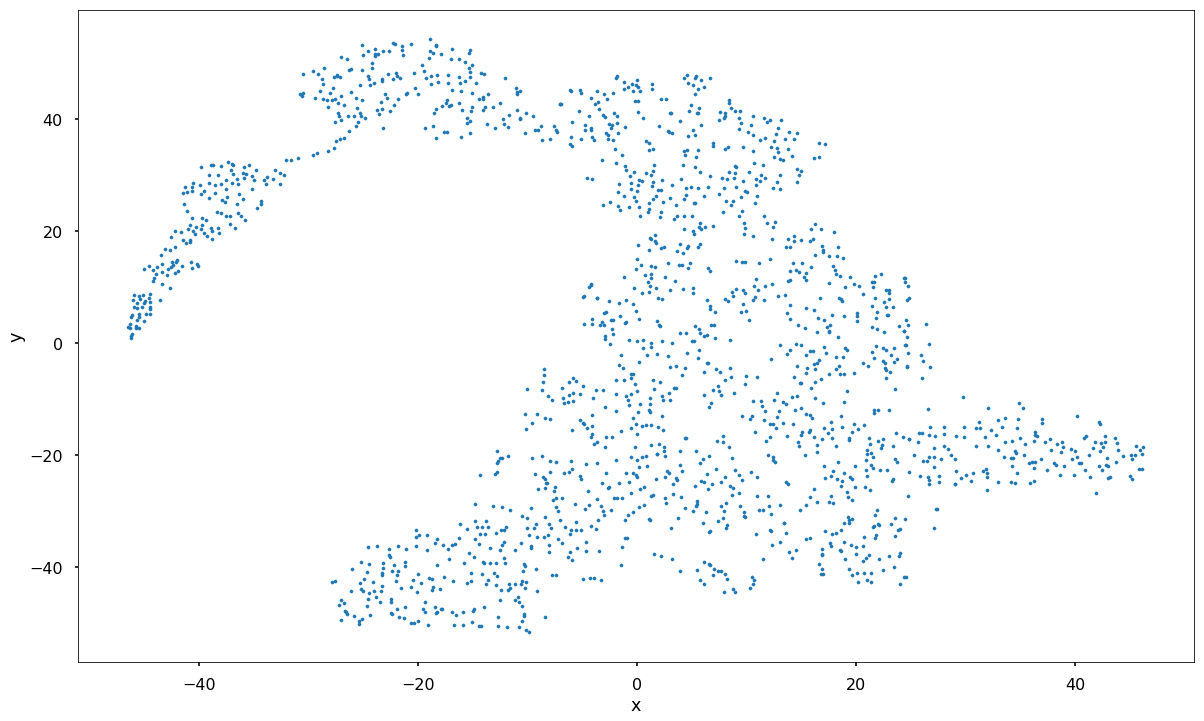

In [32]:
points.plot.scatter("x", "y", s=10, figsize=(20, 12))

In [51]:
def plot_region(x_bounds, y_bounds):
    slice = points[
        (x_bounds[0] <= points.x) &
        (points.x <= x_bounds[1]) & 
        (y_bounds[0] <= points.y) &
        (points.y <= y_bounds[1])
    ]
    
    ax = slice.plot.scatter("x", "y", s=35, figsize=(8, 8))
    for i, point in slice.iterrows():
        ax.text(point.x + 0.005, point.y + 0.005, point.word, fontsize=11)

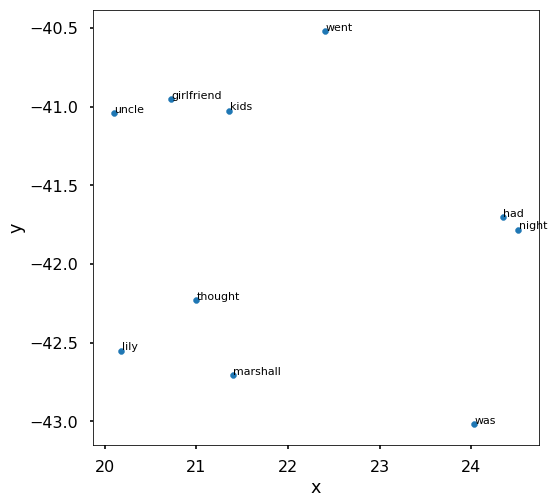

In [53]:
plot_region(x_bounds=(20.0, 50), y_bounds=(-50, -40))

In [59]:
himym2vec.wv.most_similar("man")

/home/ibtissem/anaconda3/lib/python3.6/site-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


[('today', 0.9992852807044983),
 ('mix', 0.9992297887802124),
 ('horse', 0.9992042183876038),
 ('second', 0.9991937875747681),
 ('horn', 0.9991713166236877),
 ('gun', 0.9991331100463867),
 ('painting', 0.9991319179534912),
 ('hands', 0.9991278648376465),
 ('exclaiming', 0.9991172552108765),
 ('sucks', 0.9991109371185303)]

# Word2Vec using a complete text

In [62]:
doc = lxml.etree.parse(open('ted/ted_en-20160408.xml', 'r'))
input_text = '\n'.join(doc.xpath('//content/text()'))

In [64]:
# remove parenthesis 
input_text_noparens = re.sub(r'\([^)]*\)', '', input_text)
# store as list of sentences
sentences_strings_ted = []
for line in input_text_noparens.split('\n'):
    m = re.match(r'^(?:(?P<precolon>[^:]{,20}):)?(?P<postcolon>.*)$', line)
    sentences_strings_ted.extend(sent for sent in m.groupdict()['postcolon'].split('.') if sent)
# store as list of lists of words
sentences_ted = []
for sent_str in sentences_strings_ted:
    tokens = re.sub(r"[^a-z0-9]+", " ", sent_str.lower()).split()
    sentences_ted.append(tokens)

In [66]:
model_ted = w2v.Word2Vec(sentences=sentences_ted, size=100, window=5, min_count=5, workers=num_workers, sg=0)

In [67]:
model_ted.wv.most_similar("man")

/home/ibtissem/anaconda3/lib/python3.6/site-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


[('woman', 0.838357150554657),
 ('guy', 0.814936101436615),
 ('girl', 0.7588636875152588),
 ('boy', 0.7533975839614868),
 ('lady', 0.7455140948295593),
 ('soldier', 0.7213205099105835),
 ('gentleman', 0.7079685926437378),
 ('kid', 0.6932568550109863),
 ('poet', 0.6869439482688904),
 ('david', 0.6789574027061462)]

# Fasttext

In [69]:
model_ted2 = FastText(sentences_ted, size=100, window=5, min_count=5, workers=4,sg=1)

In [70]:
model_ted2.wv.most_similar("man")

/home/ibtissem/anaconda3/lib/python3.6/site-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


[('batman', 0.7955553531646729),
 ('woman', 0.7910079956054688),
 ('ekman', 0.7813267111778259),
 ('hoffman', 0.7744827270507812),
 ('shaman', 0.7624408006668091),
 ('fireman', 0.7590819597244263),
 ('foreman', 0.7577202320098877),
 ('guy', 0.7543362379074097),
 ('lehman', 0.7483119964599609),
 ('gottman', 0.7453269958496094)]

In [71]:
model_ted2.wv.most_similar("Gastroenteritis")

/home/ibtissem/anaconda3/lib/python3.6/site-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


[('arthritis', 0.8325503468513489),
 ('kp', 0.806272029876709),
 ('anaheim', 0.7962978482246399),
 ('anthropocene', 0.7947843074798584),
 ('msf', 0.7912716865539551),
 ('h1n1', 0.7865433692932129),
 ('gbm', 0.7858266234397888),
 ('4shbab', 0.7845964431762695),
 ('iliac', 0.7838256359100342),
 ('mitochondrial', 0.7836856842041016)]

In [72]:
model_ted.wv.most_similar("Gastroenteritis")

KeyError: "word 'Gastroenteritis' not in vocabulary"